
## Help Yelp

---

In this project I will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). I'll be using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. 

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

Looking at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**I will be performing 4 different sections of analysis.**

Remember that classification targets are categorical and regression targets are continuous variables.


## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want me to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data to predict Las Vegas from the other variables I have. I should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

I may use any classification algorithm which seesms appropriate, or even multiple models. I will:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate the model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting the findings from the model(s) into a human-readable description of the city.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import patsy

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet, Ridge

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
small_biz_data = pd.read_csv('yelp_arizona_data/businesses_small_parsed.csv')

In [31]:
small_biz_data.city= [x.replace(' ','_') for x in small_biz_data.city]

In [32]:
small_biz_data.city.unique()

array(['Phoenix', 'Surprise', 'Las_Vegas', 'Waterloo'], dtype=object)

In [33]:
lv_mask = (small_biz_data['city'] == 'Las_Vegas')
small_biz_data_lv = small_biz_data [lv_mask]

In [34]:
small_biz_data_lv.head(3)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
196,l6QcUE8XXLrVH6Ydm4GSNw,Fatburger,12,Las_Vegas,3.0,"['Burgers', 'American (Traditional)', 'Fast Fo...",36.197409,-115.191385,[],attributes.Ambience.divey,False
197,VZyE9u5-gAG62zfe53hXWA,Artisan Hotel Boutique,387,Las_Vegas,3.0,"['Bars', 'Nightlife', 'Lounges', 'Hotels & Tra...",36.143672,-115.169792,[],attributes.Ambience.divey,False
198,YwUTwzYD7G25DIICSVqFBQ,Play It Again Sam,22,Las_Vegas,3.5,"['Adult Entertainment', 'Bars', 'Nightlife']",36.126894,-115.195024,['Chinatown'],attributes.Ambience.divey,True


In [35]:
phx_mask = (small_biz_data['city'] == 'Phoenix')
small_biz_data_phx = small_biz_data [phx_mask]

In [36]:
small_biz_data_phx.head(3)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False


In [37]:
small_biz_data_phx.value.unique()

array(['False', 'True', '09:00', '11:00', '07:00', '09:30', '16:00',
       '10:00', '05:00', '17:00', '21:00', '10:30', '06:00', '06:30',
       '08:00', '00:00', '15:00', '15:30', '11:30', '04:00', '14:00',
       '01:00', '12:00', '05:30', '04:30', '14:30', '20:00', '07:30',
       '13:00', '17:30', '18:00', '16:30', '18:30', '19:30', '19:00',
       'full_bar', 'none', 'beer_and_wine', 'no', 'yes_free',
       'yes_corkage', '1.0', '2.0', '3.0', '4.0', '03:00', '22:00',
       '02:00', '23:00', '20:30', '23:30', '22:30', '21:30', '12:30',
       '01:30', '01:20', '02:30', '20:15', '13:30', '23:59', '08:30',
       '15:45', '21plus', '18plus', '00:30', 'free', 'paid', '16:45',
       '19:15', 'very_loud', 'average', 'loud', 'quiet', 'outdoor', 'yes',
       'casual', 'dressy', 'formal'], dtype=object)

In [38]:
small_biz_data_lv_subset = small_biz_data_lv[['review_count','city','stars']]

In [39]:
small_biz_data_lv_subset.head(3)

,review_count,city,stars
196,12,Las_Vegas,3.0
197,387,Las_Vegas,3.0
198,22,Las_Vegas,3.5


In [40]:
small_biz_data_phx_subset = small_biz_data_phx[['review_count','city','stars']]

In [41]:
small_biz_data_phx_subset.head(4)

,review_count,city,stars
0,25,Phoenix,2.5
1,19,Phoenix,3.0
2,238,Phoenix,3.5
3,10,Phoenix,4.0


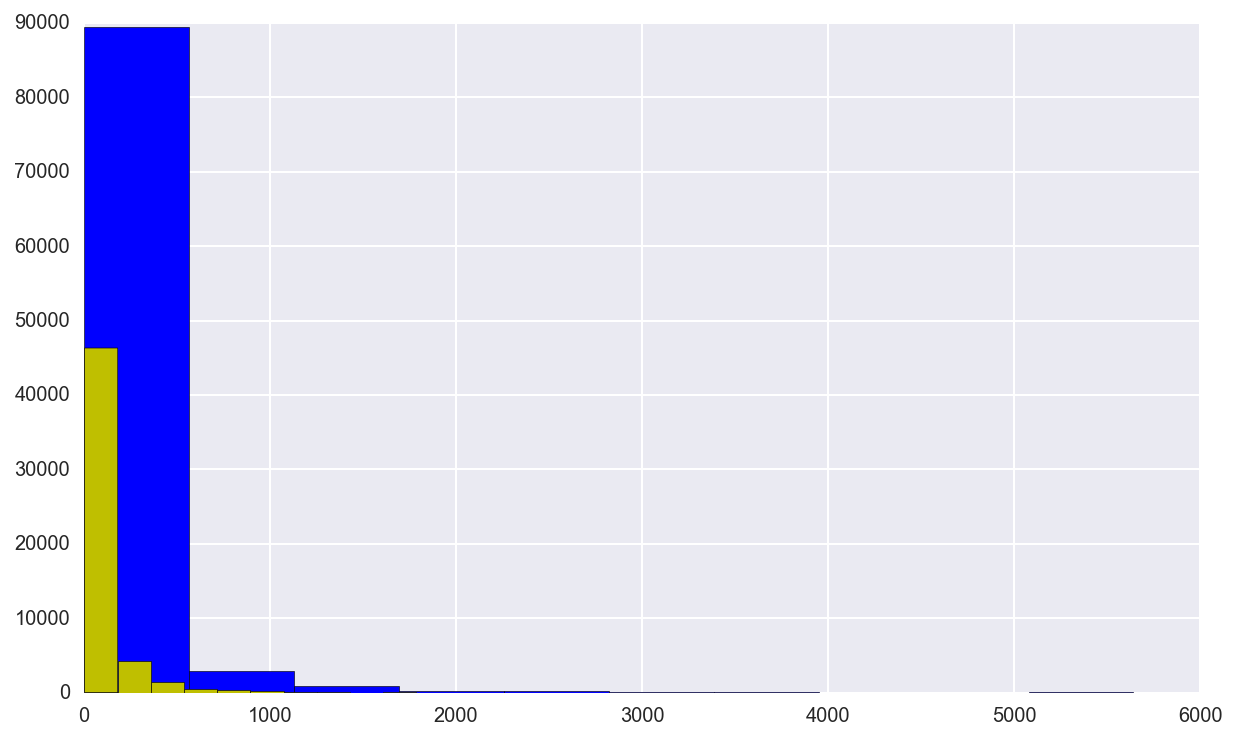

In [42]:
# Let's look at some data for Las Vegas & Phoenix: review_count
fig = plt.figure(figsize=(10,6))
small_biz_data_lv_subset['review_count'].hist(color='b', label='Review Count, Las Vegas')
small_biz_data_phx_subset['review_count'].hist(color='y', label='Review Count, Phoenix')

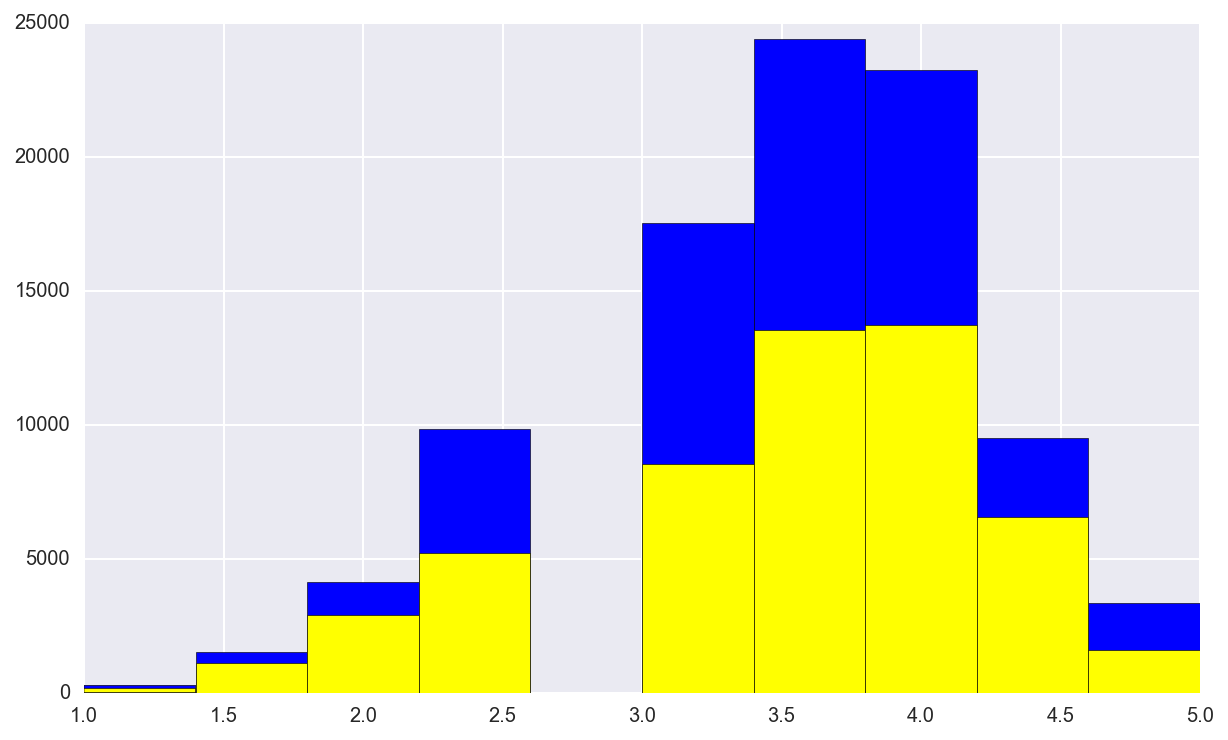

In [43]:
# And also for  Las Vegas& Phoenix: stars
fig = plt.figure(figsize=(10,6))
small_biz_data_lv_subset['stars'].hist(color='b', label='Review Count, Las Vegas')
small_biz_data_phx_subset['stars'].hist(color='yellow', label='Review Count, Phoenix')

In [44]:
# First the analysis for Las Vegas

In [45]:
import patsy

y1, X1 = patsy.dmatrices("review_count ~ stars - 1", data=small_biz_data_lv_subset, 
                       return_type="dataframe")
y1 = np.ravel(y1)

In [46]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.25)

In [47]:
cv_indices1 = StratifiedKFold(y1, n_folds=5)

In [48]:
logreg = LogisticRegression()

In [49]:
logreg.fit(X1, y1)
logreg.score(X1, y1)

0.03030335330107229

In [50]:
logreg.fit(X1_train, y1_train)
logreg.score(X1_train, y1_train)

0.0304563477964271

In [51]:
lr1_scores = []

for train_i, test_i in cv_indices1:
    
    X1_tr = X1.iloc[train_i, :] 
    y1_tr = y1[train_i]
    X1_te = X1.iloc[test_i, :] 
    y1_te = y1[test_i]
    
    #print X_tr.shape, X_te.shape
    logreg.fit(X1_tr, y1_tr)
    lr1_scores.append(logreg.score(X1_te, y1_te))
    
print 'Logistic Regression:'
print lr1_scores
print np.mean(lr1_scores)

Logistic Regression:
[0.029798006434259797, 0.030036085756739547, 0.032543747332479729, 0.030540077153879127, 0.03671056167696856]
0.0319256956709


In [52]:
print cross_val_score(logreg, X1, y1, cv=5)

[ 0.02979801  0.03003609  0.03254375  0.03054008  0.03671056]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d918190>]], dtype=object)

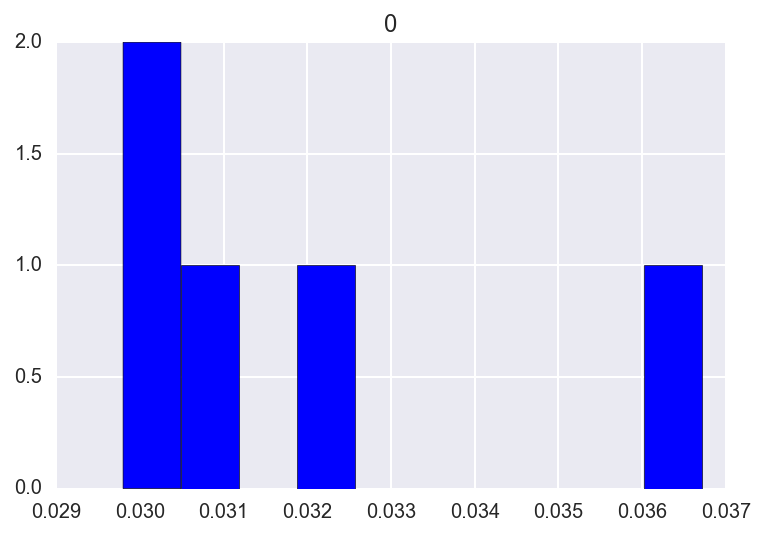

In [53]:
# Let's look at the logistic regression we got for Las Vegas: 
lr1_df = pd.DataFrame(lr1_scores)
fig = plt.figure(figsize=(10,6))
lr1_df.hist(color='b', label='Logistic Regression, Las Vegas')

In [ ]:
# Second, the analysis for Phoenix

In [54]:
y2, X2 = patsy.dmatrices("review_count ~ stars - 1", data=small_biz_data_phx_subset, 
                       return_type="dataframe")
y2 = np.ravel(y2)

In [55]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.25)

In [56]:
cv_indices2 = StratifiedKFold(y2, n_folds=5)

In [57]:
logreg2 = LogisticRegression()

In [58]:
logreg2.fit(X2, y2)
logreg2.score(X2, y2)

0.036168096248052707

In [59]:
logreg2.fit(X2_train, y2_train)
logreg2.score(X2_train, y2_train)

0.039515503390975752

In [60]:
lr2_scores = []

for train_i, test_i in cv_indices2:
    
    X2_tr = X2.iloc[train_i, :] 
    y2_tr = y2[train_i]
    X2_te = X2.iloc[test_i, :] 
    y2_te = y2[test_i]
    
    #print X_tr.shape, X_te.shape
    logreg2.fit(X2_tr, y2_tr)
    lr2_scores.append(logreg2.score(X2_te, y2_te))
    
print 'Logistic Regression:'
print lr2_scores
print np.mean(lr2_scores)

Logistic Regression:
[0.038522231504687643, 0.039226674138414123, 0.038670921719541958, 0.03926750991127053, 0.039237986920671028]
0.0389850648389


In [61]:
print cross_val_score(logreg2, X2, y2, cv=5)

[ 0.03852223  0.03922667  0.03867092  0.03926751  0.03923799]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a149590>]], dtype=object)

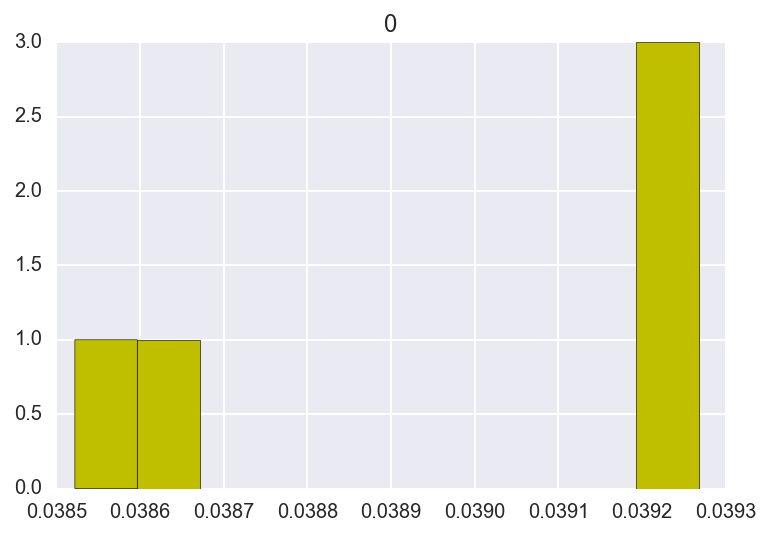

In [62]:
# Let's look at the logistic regression we got for Phoenis: 
lr2_df = pd.DataFrame(lr2_scores)
fig = plt.figure(figsize=(10,6))
lr2_df.hist(color='y', label='Logistic Regression, Phoenix')

In [ ]:
# Based on the analysis above, it seems that correlation beween review counts and stars
# is somewhat better in Phoenix that Las Vegas :( 
# Overall, these numbers are not that good, being so close to 0, which would
# indicate no correlation at all


## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? I divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. I then create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. I construct a regression model for each of the two ratings. They should use the same predictor variables (of my choice). 
4. I validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell me about the hypothesis that there are in fact two different kinds of ratings?

In [63]:
#users_small_parsed.csv 
users_small_data = pd.read_csv('yelp_arizona_data/users_small_parsed.csv')

In [64]:
users_small_data.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [65]:
users_small_data.columns = [x.replace('.','_') for x in users_small_data.columns]

In [66]:
users_small_data.head()

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [67]:
users_small_data.columns

Index([u'yelping_since', u'compliments_plain', u'review_count',
       u'compliments_cute', u'compliments_writer', u'fans',
       u'compliments_note', u'compliments_hot', u'compliments_cool',
       u'compliments_profile', u'average_stars', u'compliments_more', u'elite',
       u'name', u'user_id', u'votes_cool', u'compliments_list', u'votes_funny',
       u'compliments_photos', u'compliments_funny', u'votes_useful'],
      dtype='object')

In [70]:
users_small_data_service = users_small_data[['review_count', 'compliments_plain','compliments_note', 
                                             'compliments_more','compliments_list', 'elite',
                                            'votes_useful']]

In [71]:
users_small_data_non = users_small_data[['compliments_cute','compliments_hot', 'compliments_cool',
                                        'votes_cool', 'votes_funny', 'compliments_funny']]

In [72]:
target3 = 'review_count'
non_target_cols3 = ['compliments_plain','compliments_note','compliments_more','compliments_list', 'elite',
                                            'votes_useful']

formula3 = target3 + ' ~ ' + ' + '.join(non_target_cols3) + ' -1'

y3, X3 = patsy.dmatrices(formula3, data=users_small_data_service, 
                       return_type="dataframe")
y3 = np.ravel(y3)

In [73]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.25)

In [74]:
cv_indices3 = StratifiedKFold(y3, n_folds=5)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [75]:
logreg3 = LogisticRegression()

In [76]:
logreg3.fit(X3, y3)
logreg3.score(X3, y3)

0.018798789230524134

In [79]:
lr3_scores = []

for train_i, test_i in cv_indices3:
    
    X3_tr = X3.iloc[train_i, :] 
    y3_tr = y3[train_i]
    X3_te = X3.iloc[test_i, :] 
    y3_te = y3[test_i]
    
    #print X_tr.shape, X_te.shape
    logreg3.fit(X3_tr, y3_tr)
    lr3_scores.append(logreg3.score(X3_te, y3_te))
    
print 'Logistic Regression:'
print lr3_scores
print np.mean(lr3_scores)

Logistic Regression:
[0.0015682174594877157, 0.0, 0.0017152658662092624, 0.0, 0.0012406947890818859]
0.000904835622956


In [77]:
print cross_val_score(logreg3, X3, y3, cv=5)

[ 0.00156822  0.          0.00171527  0.          0.00124069]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b1b6890>]], dtype=object)

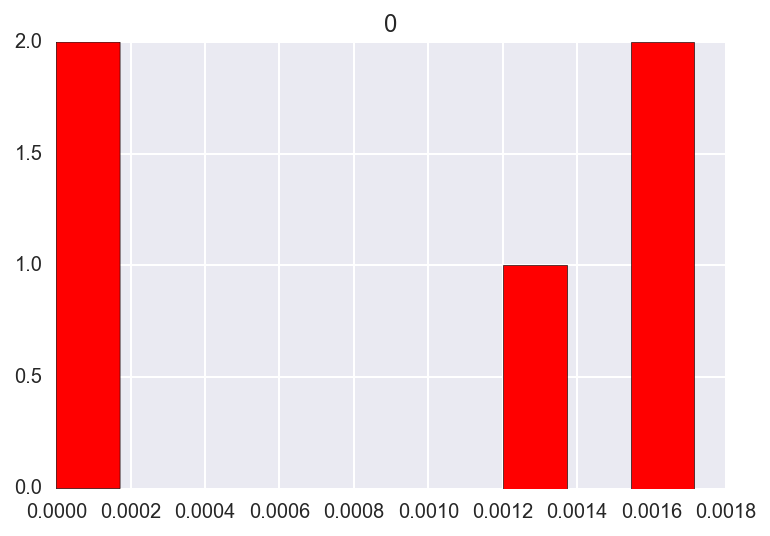

In [81]:
# Let's look at the logistic regression we got for service focused data: 
lr3_df = pd.DataFrame(lr3_scores)
fig = plt.figure(figsize=(10,6))
lr3_df.hist(color='r', label='Logistic Regression, review count')

In [82]:
target4 = 'review_count'

non_target_cols4 = ['compliments_cute','compliments_hot', 'compliments_cool',
                                        'votes_cool', 'votes_funny', 'compliments_funny']
formula4 = target4 + ' ~ ' + ' + '.join(non_target_cols3) + ' -1'

y4, X4 = patsy.dmatrices(formula4, data=users_small_data_service, 
                       return_type="dataframe")
y4 = np.ravel(y4)

In [83]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=.25)

In [84]:
cv_indices4 = StratifiedKFold(y4, n_folds=5)

In [85]:
logreg4 = LogisticRegression()

In [86]:
logreg4.fit(X4, y4)
logreg4.score(X4, y4)

0.018798789230524134

In [87]:
lr4_scores = []

for train_i, test_i in cv_indices3:
    
    X4_tr = X4.iloc[train_i, :] 
    y4_tr = y4[train_i]
    X4_te = X4.iloc[test_i, :] 
    y4_te = y4[test_i]
    
    #print X_tr.shape, X_te.shape
    logreg4.fit(X4_tr, y4_tr)
    lr4_scores.append(logreg4.score(X4_te, y4_te))
    
print 'Logistic Regression:'
print lr4_scores
print np.mean(lr4_scores)

Logistic Regression:
[0.0015682174594877157, 0.0, 0.0017152658662092624, 0.0, 0.0012406947890818859]
0.000904835622956


In [131]:
print cross_val_score(logreg4, X4, y4, cv=5)

[ 0.00156822  0.          0.00171527  0.          0.00124069]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a6ba750>]], dtype=object)

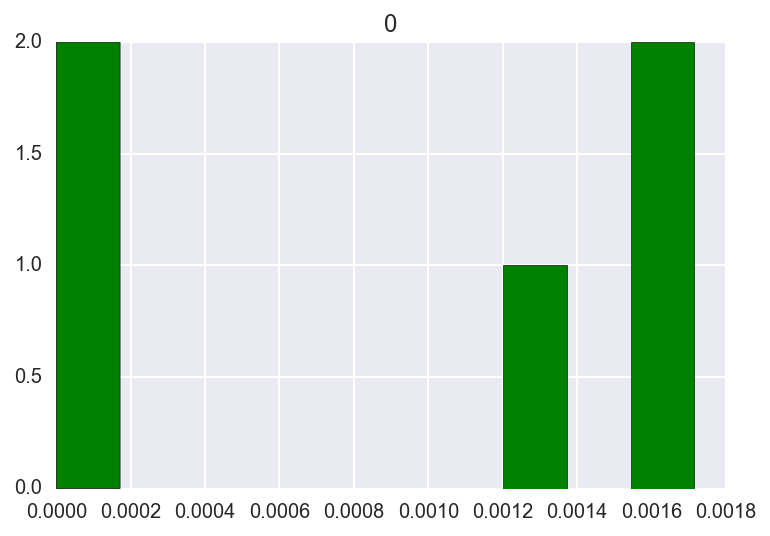

In [88]:
# Let's look at the logistic regression we got for non-service focused data: 
lr4_df = pd.DataFrame(lr4_scores)
fig = plt.figure(figsize=(10,6))
lr4_df.hist(color='g', label='Logistic Regression, review count')

In [ ]:
print "The 2 scores do not differ that much:", np.mean(lr3_scores), np.mean(lr4_scores)
print "The data does not support the idea that the ratings"
print "are for different things."


## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If I remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Let me validate the model and compare it to the one with the count variables.
- Think of a way to visually represent the results in a compelling way.
- I will then give a brief write-up of the findings.


In [125]:
users_small_data_use = users_small_data[['review_count', 'compliments_plain','compliments_note', 
                                             'compliments_more','compliments_list', 'elite',
                                            'votes_useful',
                                    'compliments_cute','compliments_hot', 'compliments_cool',
                                        'votes_cool', 'votes_funny', 'compliments_funny']]

In [126]:
# We'll use 'elite' as our target
# and all the other cols as the variables

target5 = 'elite'
non_target_cols5 = [x  for x  in users_small_data_use.columns if x != target5]

formula5 = target5 + ' ~ ' + ' + '.join(non_target_cols5) + ' -1'
print formula5

elite ~ review_count + compliments_plain + compliments_note + compliments_more + compliments_list + votes_useful + compliments_cute + compliments_hot + compliments_cool + votes_cool + votes_funny + compliments_funny -1


In [127]:
# Create the X and Y pairs for our data
Y5, X5 = patsy.dmatrices(formula5, data=users_small_data_use)

In [128]:
simple_feature_names5 = X5.design_info.column_names

In [129]:
from cycler import cycler

from ipywidgets import *
from IPython.display import display


def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2) 
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [132]:
ridge_reg5 = Ridge()

ridge_reg5_scores = []

def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    #ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg5.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg5.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg5.coef_[0])
        ridge_reg5_scores.append(ridge_reg5.score(X, Y))

        
    return coefs

In [133]:

r_alphas5 = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs5 = ridge_coefs(X5, Y5, r_alphas5)

In [134]:
print cross_val_score(ridge_reg5, X5, Y5, cv=5)

[-0.02641321  0.00600185 -0.00095994  0.00682146  0.00289127]


In [136]:
print "Ridge Regression scores:", ridge_reg5_scores[0:5]

Ridge Regression scores: [0.013292291084091842, 0.013292291084091076, 0.013292291084091199, 0.013292291084090944, 0.013292291084092021]


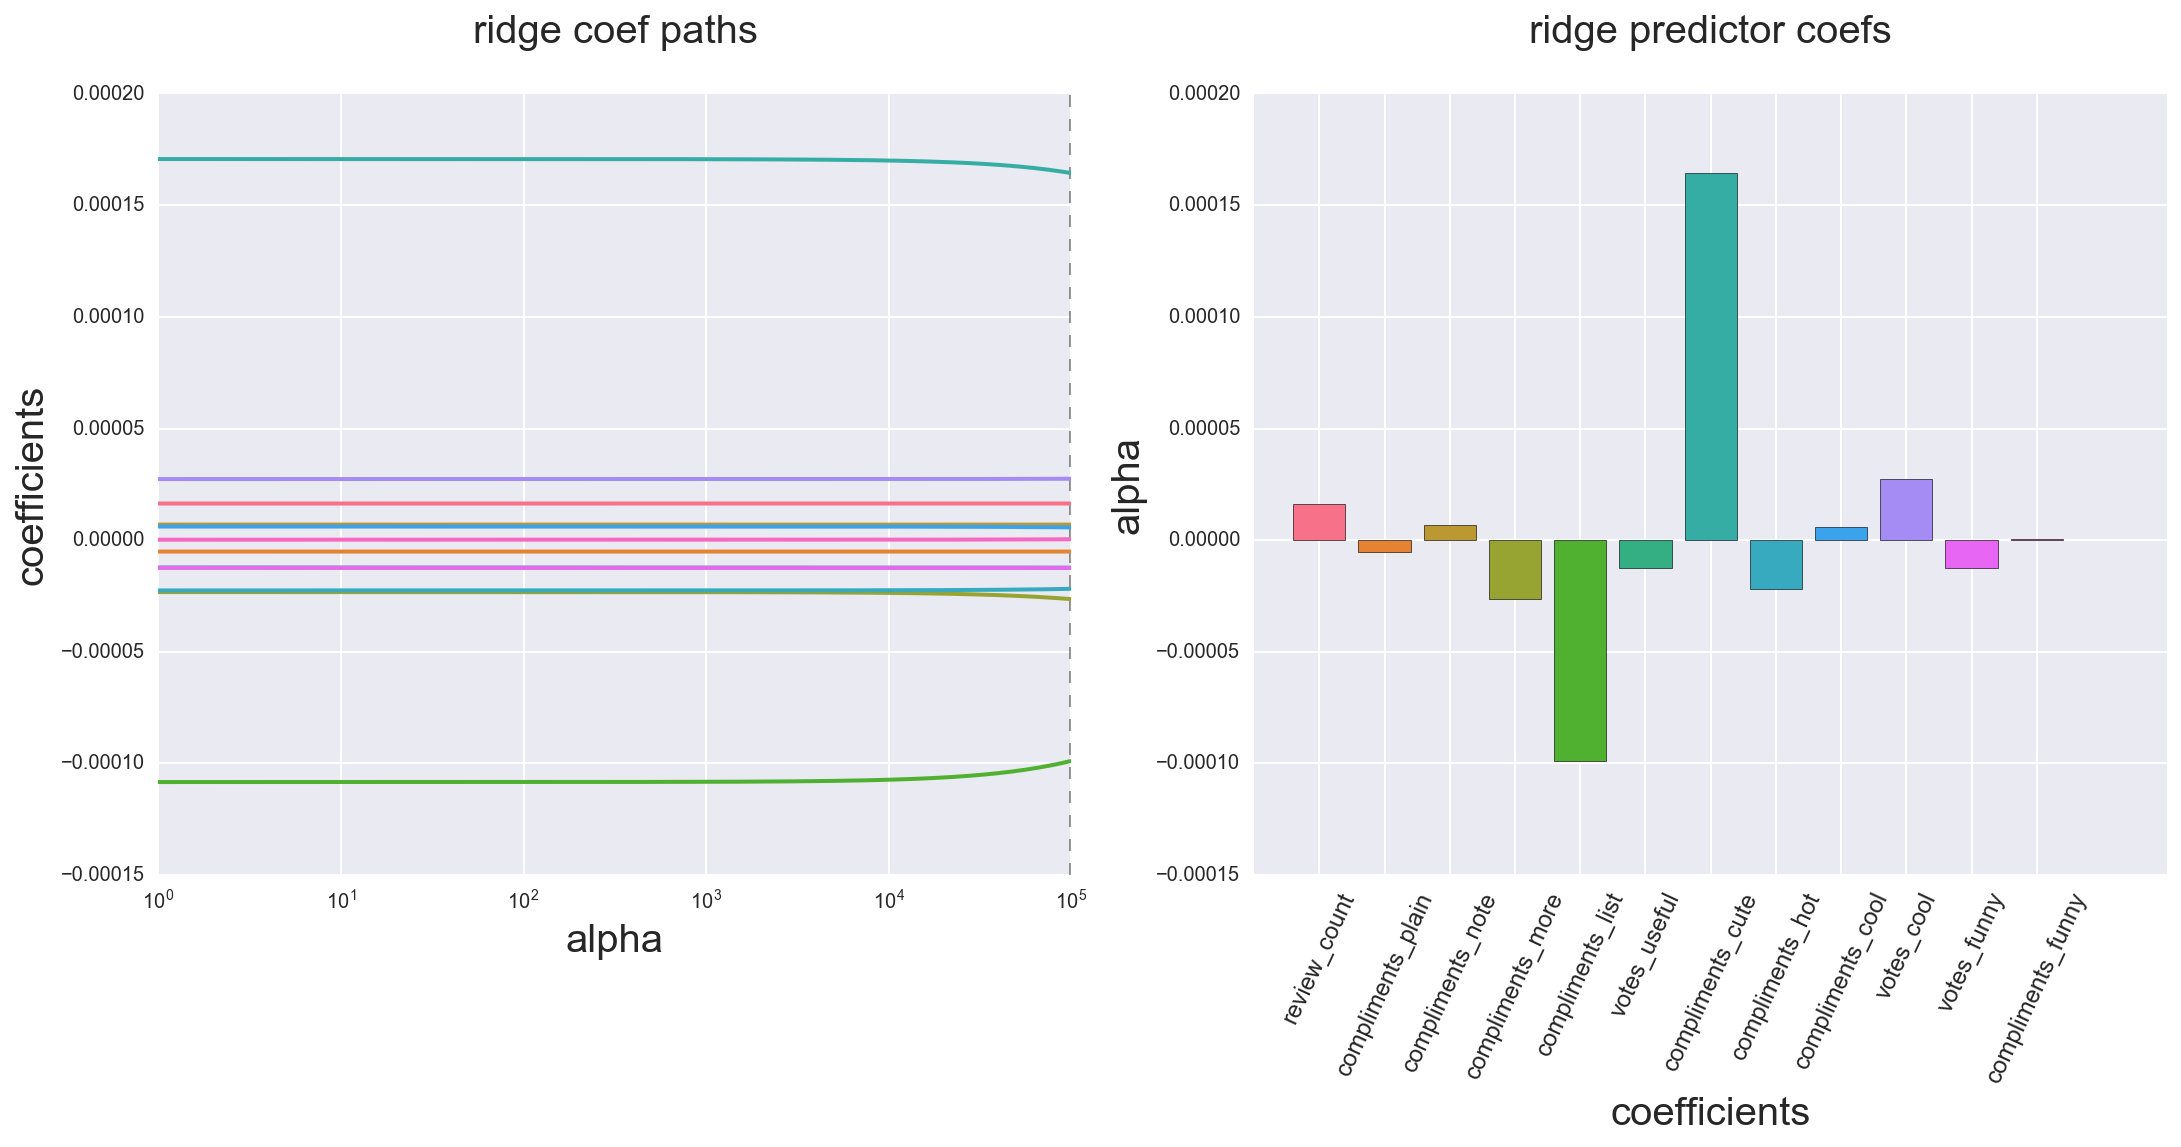

<function __main__.ridge_plot_runner>

In [137]:
def ridge_plot_runner(log_of_alpha=6):
    coef_plotter(r_alphas5, r_coefs5, simple_feature_names5, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))